In [1]:
# Importing all the necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.
d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python

In [3]:
# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

In [4]:
GLOVE_DIR = "C:\\Users\\itska\\Desktop\\btech project\\project\\glove"
EMBEDDING_DIM = 50
num_epochs = 7
step_epochs = 2
val_steps = 149

In [5]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

In [6]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    # x = Dense(1024, activation='relu')(x)
    # and a logistic layer with 2 classes
    return x

In [7]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [8]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [9]:
training_DF.head()

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,official bernie sanders drinking game every ti...,0
1,qDnIIHA.png,228 pm wall inside nazi gas chamber dwebs demo...,1
2,1JQk5NF.png,shit waddup bernie sanders com,1
3,iMMNq.png,mitt romney worst republican country putup bar...,0
4,jAi3iI1.png,anonymous id duqda1io 08 05 16 fri 163248 8423...,0


In [10]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [11]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [12]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [13]:
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [14]:
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [15]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

W1109 01:25:56.471262 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [17]:
from keras import regularizers

In [18]:
# Defining second LSTM
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')
# Adding embedding layer
embedded_sequences = embedding_layer(main_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
lstm1 = LSTM(32, return_state=True)
encoder_outputs,state_h,state_c = (lstm1)(x)
states= [state_h,state_c]

W1109 01:25:59.159078 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 01:25:59.161679 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1109 01:25:59.191264 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1109 01:25:59.192769 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1109 01:25:59.259813 10056 deprecation_wrapper

In [19]:
# Defining second LSTM
lstm2=LSTM(32, return_sequences=True, return_state=True)
decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
lstm_out = Flatten()(decoder_out)
txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [20]:
# Defining text model
txt_model = Model(inputs = [main_input], outputs=txt_out)

In [21]:
# Compile text model
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

W1109 01:26:02.911679 10056 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 01:26:02.921247 10056 deprecation.py:323] From d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
# Plot text model
plot_model(txt_model, to_file='CNN_txt_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [23]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs = num_epochs, validation_steps = val_steps, steps_per_epoch=step_epochs, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 10s 5s/step - loss: 0.8196 - acc: 0.3906 - val_loss: 0.6995 - val_acc: 0.4631
Epoch 2/7
2/2 [==============================] - 10s 5s/step - loss: 0.8012 - acc: 0.4062 - val_loss: 0.6844 - val_acc: 0.5705
Epoch 3/7
2/2 [==============================] - 10s 5s/step - loss: 0.7608 - acc: 0.7031 - val_loss: 0.6688 - val_acc: 0.6107
Epoch 4/7
2/2 [==============================] - 8s 4s/step - loss: 0.8510 - acc: 0.5625 - val_loss: 0.6713 - val_acc: 0.6107
Epoch 5/7
2/2 [==============================] - 11s 5s/step - loss: 0.8260 - acc: 0.5781 - val_loss: 0.6807 - val_acc: 0.6040
Epoch 6/7
2/2 [==============================] - 8s 4s/step - loss: 0.7986 - acc: 0.6094 - val_loss: 0.6906 - val_acc: 0.5705
Epoch 7/7
2/2 [==============================] - 9s 5s/step - loss: 0.8233 - acc: 0.6406 - val_loss: 0.7026 - val_acc: 0.4362


In [24]:
# Saving text model
txt_model.save('CNN_txt_model.h5')

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


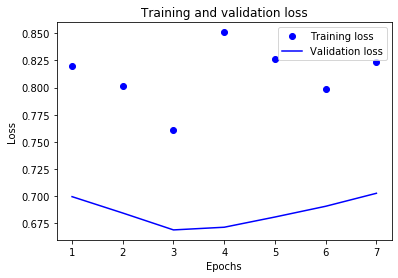

In [25]:
# Plotting training and validation loss 
loss_values = txt_model.history.history['loss']
val_loss_values = txt_model.history.history['val_loss']
epochs = range(1, 7 + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Predicting labels using text model
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
y_true = y_test.values

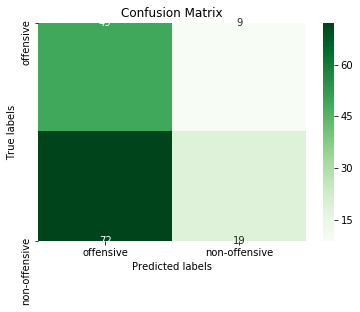

In [27]:
# Confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);
plt.show()

In [28]:
# Loading pre-trained image model
img_model = load_model('VGG16_img_model.h5')

In [29]:
# Compiling models
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [30]:
# Concatenating the output of 2 classifiers
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [31]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [32]:
# compiling the combined model
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [33]:
# Plot model
plot_model(com_model, to_file='Two_LSTM_Inception_mul_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [34]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 31s 16s/step - loss: 0.8252 - acc: 0.5625 - val_loss: 0.7602 - val_acc: 0.3356
Epoch 2/7
2/2 [==============================] - 28s 14s/step - loss: 0.8517 - acc: 0.4531 - val_loss: 0.7689 - val_acc: 0.3490
Epoch 3/7
2/2 [==============================] - 27s 13s/step - loss: 0.8409 - acc: 0.4375 - val_loss: 0.7339 - val_acc: 0.4497
Epoch 4/7
2/2 [==============================] - 27s 13s/step - loss: 0.8447 - acc: 0.4219 - val_loss: 0.7508 - val_acc: 0.3826
Epoch 5/7
2/2 [==============================] - 26s 13s/step - loss: 0.8318 - acc: 0.4062 - val_loss: 0.7298 - val_acc: 0.4564
Epoch 6/7
2/2 [==============================] - 26s 13s/step - loss: 0.8197 - acc: 0.5000 - val_loss: 0.7113 - val_acc: 0.4899
Epoch 7/7
2/2 [==============================] - 27s 13s/step - loss: 0.8421 - acc: 0.5000 - val_loss: 0.7313 - val_acc: 0.4497


In [35]:
# saving combined model
com_model.save("Two_LSTM_Inception_mul_model.h5")

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


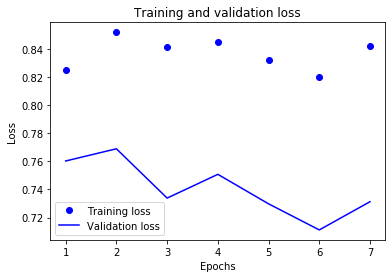

In [36]:
# Plotting training and validation loss for combined model
loss_values = com_model.history.history['loss']
val_loss_values = com_model.history.history['val_loss']
epochs = range(1, num_epochs + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Predicting true labels using combined classifier
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

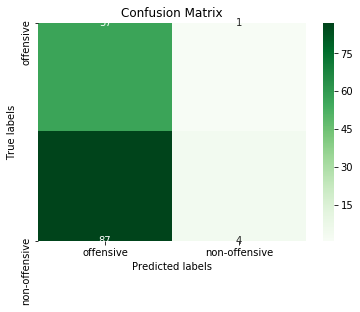

In [38]:
# Confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);
# plt.figure(figsize=(5,6))

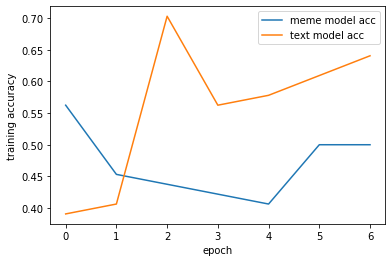

In [39]:
# Plotting model training accuracies
plt.plot(com_model.history.epoch, com_model.history.history['acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'text model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

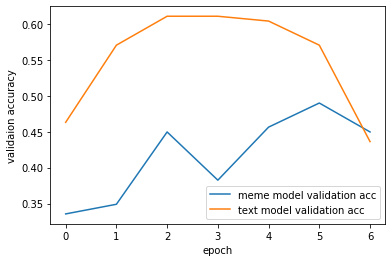

In [40]:
# Plotting model validation accuracies
plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'text model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [41]:
# Loss and accuracy for combined model
com_model.evaluate_generator(img_txt_gen_test, steps=149)

[0.6986154997908829, 0.5167785234899329]

In [42]:
# Loss and accuracy for text model
txt_model.evaluate_generator(txt_gen_test, steps=149)

[0.7247354978282979, 0.3825503355704698]

In [43]:
from sklearn.metrics import precision_recall_fscore_support

In [44]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average='binary')

(0.4049586776859504, 0.8448275862068966, 0.547486033519553, None)

In [45]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average='binary')

(0.3958333333333333, 0.9827586206896551, 0.5643564356435643, None)